# FIT5149 S2 2020 
# Assessment 1: Predict the rotor temperature given the collected data


Student information
- Family Name: Singh
- Given Name: Shubham
- Student ID: 30145945
- Student email: ssin0051@student.monash.edu

Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used:
- dplyr version 1.0.1 in R packages
- ggplot2 version 3.3.2 in R packages 
- reshape2 version 1.4.4 in R packages
- reshape version 0.8.8 in R packages
- visdat version 0.5.3 in R packages
- psych version 2.0.8 in R packages
- lattice version 0.20.38 in R packages
- randomForest version 4.6.14 in R packages
- hydroGOF version 0.4.0 in R packages
- e1071 version 1.7.3 in R packages
- caret version 6.0.86 in R packages

## Table of Contents

1. [Introduction](#sec_1)
3. [Exploratory Data Analysis](#sec_3)
3. [Methodology](#sec_4)
3. [Model Development](#sec_5)
3. [Results and discussion](#sec_6)
3. [Conclusion](#sec_7)
3. [References](#sec_8)

## 1. Introduction <a class="anchor" id="sec_1"></a>

- The main purpose of the data set’s recording is to be able to model the rotor temperatures of a permanent magnet synchronous motor (PMSM) in real-time. 
- Due to the intricate structure of an electric traction drive, direct measurement with thermal sensors is not possible for rotor temperatures, and even in case of the stator temperatures, sensor outage or even just deterioration can’t be ad- ministered properly without redundant modeling. 
- In addition, precise thermal modeling gets more and more important with the rising relevance of functional safety.
- Ourtask is to design a model with appropriate feature engineering, that estimates one target temperature rotor temperature (“pm”) in a causal manner. 
- In order to maintain real-time capability, model sizes should be as small as possi- ble, while retain a high level of prediction accuracy, as temperature estimation in production will be deployed on best-cost hardware of traction drives in an au- tomotive environment, where lean computation and lightweight implementation is key and crucial.
- The first section of the notebook shows the exploratory data analysis (EDA) performed to explore and understand the data. It looks at each attribute (variable) in the data to understand the nature and distribution of the attribute values. It also examines the correlation between the variables through visual analysis. A summary at the end highlights the key findings of the EDA.
- The second section shows the development of the linear regression model. It details the process used to build the model and shows the model at key points in the development process. The final model is then presented along with an analysis and interpretation of the model. This section concludes with the results of using the model to __predict rotor tempreature__ for the data in the development dataset.

## 2. Exploratory Data Analysis<a class="anchor" id="sec_3"></a>

Exploratort Data Analysis(EDA) is the process of data exploration, where a number of techniques are used to better understand the dataset being used.<br>

Understanding of dataset is very important to know the following:
   - selecting important feature and rejecting less important
   - identityfying outliers, missing values and human errors
   - Understanding the relationship(s), or lack of, between variables
   - minimizing potential error that may occur later in the process

In [ ]:
options(warn = -1)

In [1]:
#install.packages("reshape")
library(reshape)
#install.packages("visdat")
library(visdat)
#install.packages("psych")
library(psych)
#install.packages("hydroGOF")
library(hydroGOF)
#install.packages("e1071")
library(e1071)
#install.packages("caret")
library(caret)
#install.packages("ggplot2")
library(ggplot2)
#install.packages("dplyr")
library(dplyr)
#install.packages("randomForest")
library(randomForest)
#install.packages("reshape2")
library(reshape2)
#install.packages("RColorBrewer")
library(RColorBrewer)
#install.packages("corrplot")
library(corrplot)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: lattice

Loading required package: ggplot2


Attaching package: 'ggplot2'


The following objects are masked from 'package:psych':

    %+%, alpha



Attaching package: 'dplyr'


The following object is masked from 'package:reshape':

    rename


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:psych':

    outlier



Attaching package: 'reshape2'


The following objects are masked from 'package:reshape':

  

#### Data set
The dataset used in this assessment is generated based on the full dataset with a reduced size. Therefore, please download the data set from Moodle. You are not allowed to use the original dataset available on the Kaggle website. Please note that the three original target features “stator yoke”, “stator winding” and “stator tooth” should not be used.

In [2]:
# Load the training dataset
pmsm <- read.csv("pmsm_temperature_data_A1_2021.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)

# Droping “stator yoke”, “stator winding” and “stator tooth” from dataset
pmsm <- pmsm[c(-10,-11,-12)]
attach(pmsm)

In [3]:
# Display the dimensions
cat("The housing dataset has", dim(pmsm)[1], "records, each with", dim(pmsm)[2],
    "attributes. The structure is:\n\n")

# Display the structure
str(pmsm)

The housing dataset has 15147 records, each with 10 attributes. The structure is:

'data.frame':	15147 obs. of  10 variables:
 $ ambient    : num  0.118 -0.555 -0.772 0.22 0.402 ...
 $ coolant    : num  -1.04 -1.09 -1.06 -1.08 -1.08 ...
 $ u_d        : num  -1.027 -1.226 0.299 -1.026 0.316 ...
 $ u_q        : num  0.925 0.513 0.956 0.928 -0.709 ...
 $ motor_speed: num  1.212 2.024 -0.14 1.212 -0.952 ...
 $ torque     : num  0.359 0.284 -0.259 0.357 -0.256 ...
 $ i_d        : num  -0.834 -1.364 1.029 -0.838 1.029 ...
 $ i_q        : num  0.323 0.234 -0.246 0.323 -0.246 ...
 $ pm         : num  -0.0883 0.7104 -1.5926 -0.1417 -1.9649 ...
 $ profile_id : int  4 4 4 4 4 4 4 4 4 4 ...


### The contents of individual variables are as follows. 

__`ambient(Decimal)`__: Ambient temperature as measured by a thermal sensor located closely to the stator.<br>
__`coolant(Decimal)`__: Coolant temperature. The motor is water cooled. Measurement is taken at outflow.<br>
__`u_d(Decimal)`__: Voltage d-component<br>
__`u_q(Decimal)`__: Voltage q-component<br>
__`motor_speed(Decimal)`__: Motor speed<br>
__`torque(Decimal)`__: Torque induced by current.<br>
__`i_d(Decimal)`__: Current d-component<br>
__`i_q(Decimal)`__: Current q-component<br>
__`pm(Decimal)`__: Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared <br>
__`profile_id(id)`__:<br>

In [4]:
cat("\nThe first few and last few records in the dataset are:")
# Inspect the first few records
head(pmsm)
# And the last few
tail(pmsm)

cat("\nBasic statistics for each attribute are:")
# Statistical summary 
summary(pmsm)


The first few and last few records in the dataset are:

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,profile_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1176819,-1.040829,-1.0267303,0.9250645,1.2124813,0.3586899,-0.8343090,0.3229330,-0.08831267,4
2,-0.5547717,-1.087189,-1.2258921,0.5125759,2.0241232,0.2841797,-1.3638294,0.2340145,0.71040170,4
3,-0.7722329,-1.063652,0.2988575,0.9562448,-0.1402458,-0.2591392,1.0291220,-0.2457111,-1.59260400,4
4,0.2199584,-1.083475,-1.0261079,0.9278145,1.2124836,0.3574240,-0.8381095,0.3228101,-0.14167030,4
5,0.4015749,-1.078981,0.3155328,-0.7094008,-0.9518901,-0.2562895,1.0291730,-0.2457109,-1.96488810,4
6,-0.7697667,-1.089577,0.2999456,0.9589649,-0.1402460,-0.2592790,1.0291333,-0.2457186,-1.77564350,4


,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,profile_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
15142,-0.6974700,1.49688820,0.3176318,-1.324828,-1.22242870,-0.2556397,1.0291415,-0.2457166,-0.835639600,81
15143,-0.1489317,1.74755540,0.2998942,-1.294876,-1.22242950,-0.2556397,1.0291376,-0.2457070,-0.993255400,81
15144,-0.5091294,1.46453430,-0.7905264,1.208344,0.80467504,0.3245067,-0.2590534,0.3256622,-0.004079474,81
15145,-0.1557110,-0.04516133,0.3011341,-1.294293,-1.22243130,-0.2556397,1.0291479,-0.2457459,-0.771475800,81
15146,-0.1561356,-0.04458057,0.3000615,-1.293905,-1.22242890,-0.2556397,1.0291611,-0.2456962,-0.663378950,81
15147,-0.7672885,-0.30993983,0.3228580,1.125235,-0.03886923,-0.2813110,1.0211550,-0.2752085,-1.903265100,81



Basic statistics for each attribute are:

    ambient           coolant              u_d               u_q         
 Min.   :-3.3278   Min.   :-1.23704   Min.   :-1.6537   Min.   :-1.8146  
 1st Qu.:-0.5390   1st Qu.:-0.69087   1st Qu.:-0.4860   1st Qu.:-1.2683  
 Median :-0.1403   Median :-0.04497   Median : 0.3001   Median :-0.3806  
 Mean   :-0.1074   Mean   : 0.18125   Mean   : 0.1102   Mean   :-0.1910  
 3rd Qu.: 0.4981   3rd Qu.: 1.00946   3rd Qu.: 0.3503   3rd Qu.: 0.7410  
 Max.   : 2.7106   Max.   : 2.29464   Max.   : 2.2735   Max.   : 1.7702  
  motor_speed          torque              i_d               i_q          
 Min.   :-1.2224   Min.   :-3.31634   Min.   :-3.1764   Min.   :-3.30867  
 1st Qu.:-1.2224   1st Qu.:-0.25765   1st Qu.:-0.5524   1st Qu.:-0.24579  
 Median :-0.4318   Median :-0.25564   Median : 0.5874   Median :-0.24571  
 Mean   :-0.1913   Mean   :-0.08396   Mean   : 0.1775   Mean   :-0.08147  
 3rd Qu.: 0.6743   3rd Qu.: 0.35654   3rd Qu.: 1.0291   3rd Qu.: 0.34990  
 Max.   : 2.0241   Max.   : 3.01

#### Exploring data for Numerical attributes

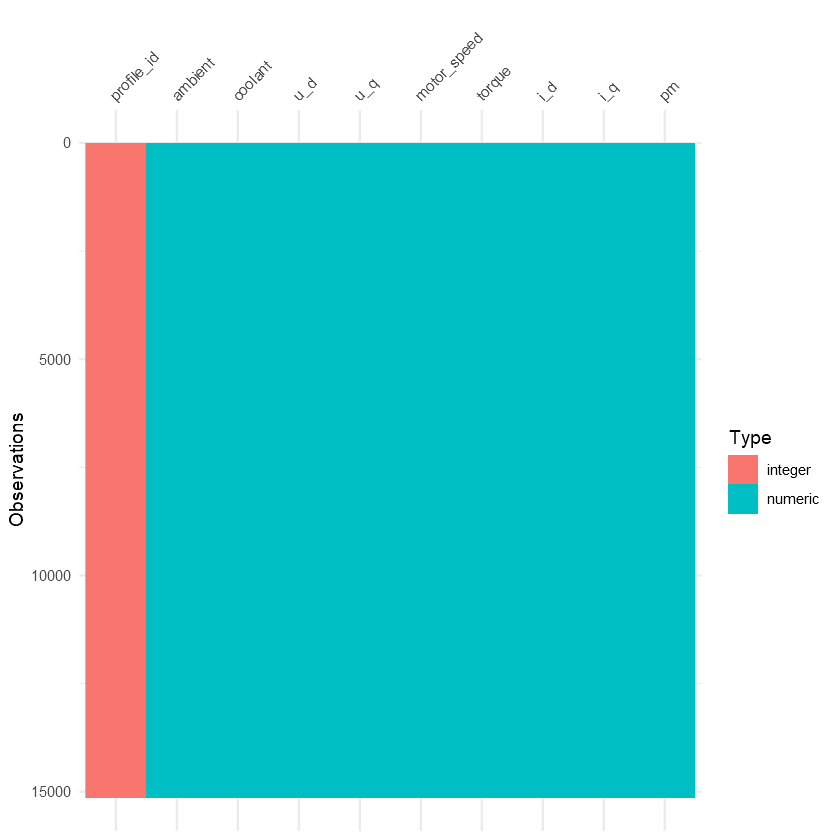

In [5]:
#Check the data type of varaibles
vis_dat(pmsm)

- Total we have 13 columns or feature in given data.
- All the columns except __profile_id__ are in __numeric__ datatype
- __Profile_id__ column has __integer__ value
- By looking at value i can say there may be outliers in columns like __ambiant__, __u_d__, __tourqe__, __i_q__ etc.

#### Check if any __data is missing or has NA values__ in the loaded data
When we perform data analysis, data containing missing values is frequently encountered. However, this dataset does not contain any missing value.

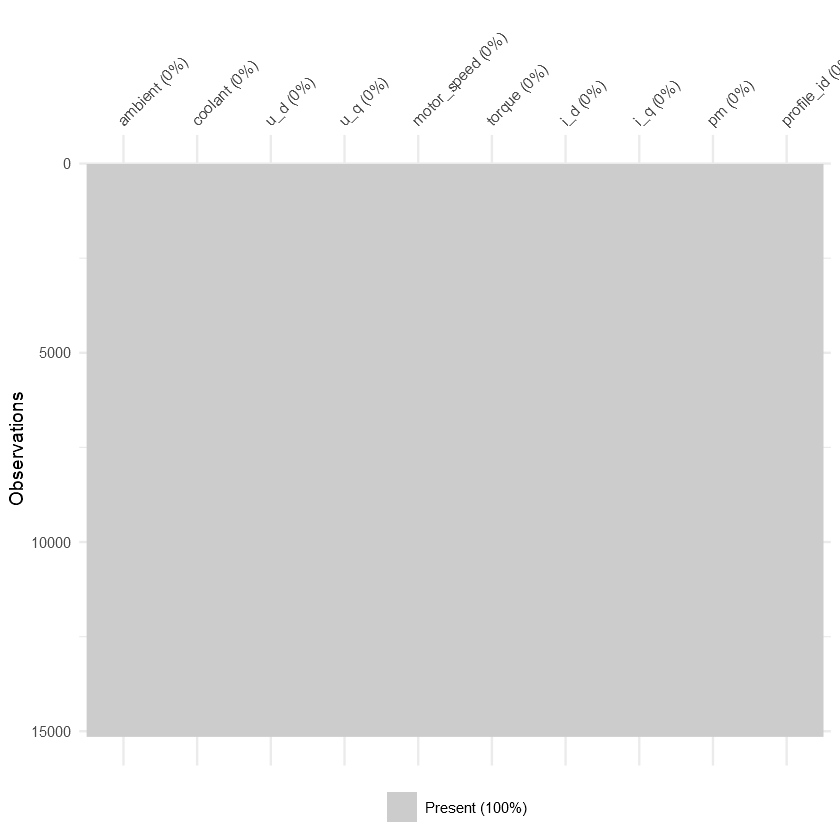

In [6]:
# Check for missing values in data using 
vis_miss(pmsm)

We can see from the above graph there is no missing values in dataset.

#### Checking for __NA__ value 

In [7]:
#Check if any NA values are present in any columns of a data
apply(pmsm, 2, function(x) any(is.na(x)))

ambient     coolant         u_d         u_q motor_speed      torque 
      FALSE       FALSE       FALSE       FALSE       FALSE       FALSE 
        i_d         i_q          pm  profile_id 
      FALSE       FALSE       FALSE       FALSE

#### Checkinh for unique value

In [8]:
# Checking unique value for all the columns
cat("The numbers of unique values for each attribute are:")
apply(pmsm, 2, function(x) length(unique(x)))

The numbers of unique values for each attribute are:

ambient     coolant         u_d         u_q motor_speed      torque 
      14263       14513       15126       15100        9434        9788 
        i_d         i_q          pm  profile_id 
      10484       12451       15139          52

### fiinding the skewnees and kurtosis for a data

describe() computes descriptive statistics for numerical data. The descriptive statistics help determine the distribution of numerical variables. Like function of dplyr, the first argument is the tibble (or data frame). The second and subsequent arguments refer to variables within that data frame.

The variables of the tbl_df object returned by describe() are as follows.

- n : number of observations excluding missing values
- na : number of missing values
- mean : arithmetic average
- sd : standard deviation
- se_mean : standard error mean. sd/sqrt(n)
- IQR : interquartile range (Q3-Q1)
- skewness : skewness
- kurtosis : kurtosis
- p25 : Q1. 25% percentile
- p50 : median. 50% percentile
- p75 : Q3. 75% percentile
- p01, p05, p10, p20, p30 : 1%, 5%, 20%, 30% percentiles
- p40, p60, p70, p80 : 40%, 60%, 70%, 80% percentiles
- p90, p95, p99, p100 : 90%, 95%, 99%, 100% percentiles

Let us look at some more statistics of the tempreature data. 

- __Mean__: The mean (average) is the sum of all numbers in the data set ,divided by the total number of values.

- __Standard deviation(sd)__: The standard deviation is a measure of the amount of variation or dispersion of a set of values. A low standard deviation has values closer to mean of the data and high standard deviation has values away from the mean of the data. 

- __Median__: The median is the middle value when a data set is ordered in ascending order.

- __Trimmed Mean__: A trimmed mean removes a proportion of the largest and smallest observations and then takes the average of the numbers that remain in the dataset.

- __Range__: Range is the difference between largest & smallest values in the dataset.

- __Mean absolute Devaition(mad)__:Mean absolute deviation (MAD) of a data set is the average distance between each data value and the mean. 

- __Skew__: Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.

- __Kurtosis__:  Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.

- __Standard error(se)__: The magnitude of the standard error gives an index of the precision of the estimate of the parameter.

In [9]:
describe(pmsm)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ambient,1,15147,-0.10739655,0.8329683,-0.14028142,-0.06174313,0.7209201,-3.327762,2.710575,6.038337,-0.64807481,1.8063443,0.006768075
coolant,2,15147,0.18124771,1.0321194,-0.04497305,0.11050250,1.1787429,-1.237039,2.294643,3.531683,0.46240105,-1.0733935,0.008386227
u_d,3,15147,0.11019371,0.9220799,0.30010197,0.09467639,0.5806362,-1.653711,2.273458,3.927169,0.01785533,-0.1781162,0.007492129
u_q,4,15147,-0.19096468,1.0496645,-0.38063500,-0.27708898,1.3511849,-1.814612,1.770184,3.584796,0.41875933,-1.2659929,0.008528785
motor_speed,5,15147,-0.19125923,1.0272826,-0.43180645,-0.29377896,1.1721783,-1.222439,2.024132,3.246571,0.53808645,-1.1064501,0.008346927
torque,6,15147,-0.08395795,0.9168406,-0.25563973,-0.09302823,0.4894976,-3.316342,3.013790,6.330132,0.16198566,1.4394998,0.007449558
i_d,7,15147,0.17748119,0.9690157,0.58743656,0.31584447,0.6548881,-3.176439,1.060168,4.236606,-0.83478383,-0.4706967,0.007873494
i_q,8,15147,-0.08146842,0.9167172,-0.24570811,-0.08938232,0.5368236,-3.308669,2.914178,6.222847,0.12262161,1.4412679,0.007448555
pm,9,15147,-0.12677864,0.9198188,-0.12050689,-0.12073181,0.9821184,-2.605213,2.905198,5.510411,-0.01404048,-0.2376653,0.007473757


__skewness__ : The left-skewed distribution data that is the variables with large positive skewness should consider the log or sqrt transformations to follow the normal distribution. 
The variables __ambient,coolant,u_q,i_d__ seem to need to consider variable transformation.

__mean and sd, se_mean__ : ThePopulation with a large standard error of the mean(se_mean) has low representativeness of the arithmetic mean(mean). The standard deviation(sd) is much larger than the arithmetic average.

#### Exploring records for a particular profile id for better understanding

In [10]:
# Checking records for some profile_id
chk_profile <- pmsm %>% filter(profile_id %in% c(4,5,6))
chk_profile

ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,profile_id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.11768189,-1.040829,-1.0267303,0.92506450,1.2124813,0.3586899,-0.8343090,0.3229330,-0.08831267,4
-0.55477166,-1.087189,-1.2258921,0.51257590,2.0241232,0.2841797,-1.3638294,0.2340145,0.71040170,4
-0.77223290,-1.063652,0.2988575,0.95624477,-0.1402458,-0.2591392,1.0291220,-0.2457111,-1.59260400,4
0.21995842,-1.083475,-1.0261079,0.92781450,1.2124836,0.3574240,-0.8381095,0.3228101,-0.14167030,4
0.40157494,-1.078981,0.3155328,-0.70940083,-0.9518901,-0.2562895,1.0291730,-0.2457109,-1.96488810,4
-0.76976670,-1.089577,0.2999456,0.95896494,-0.1402460,-0.2592790,1.0291333,-0.2457186,-1.77564350,4
-0.80973580,-1.082835,0.2943876,0.93226016,-0.1402471,-0.2594522,1.0291189,-0.2457091,-0.35324594,4
0.06131161,-1.061752,-1.0256047,0.92832190,1.2124828,0.3580676,-0.8367535,0.3225468,-0.14990744,4
0.13504969,-1.094490,-1.0267357,0.92566895,1.2124823,0.3586514,-0.8380999,0.3228803,-0.13749744,4


No id variables; using all as measure variables



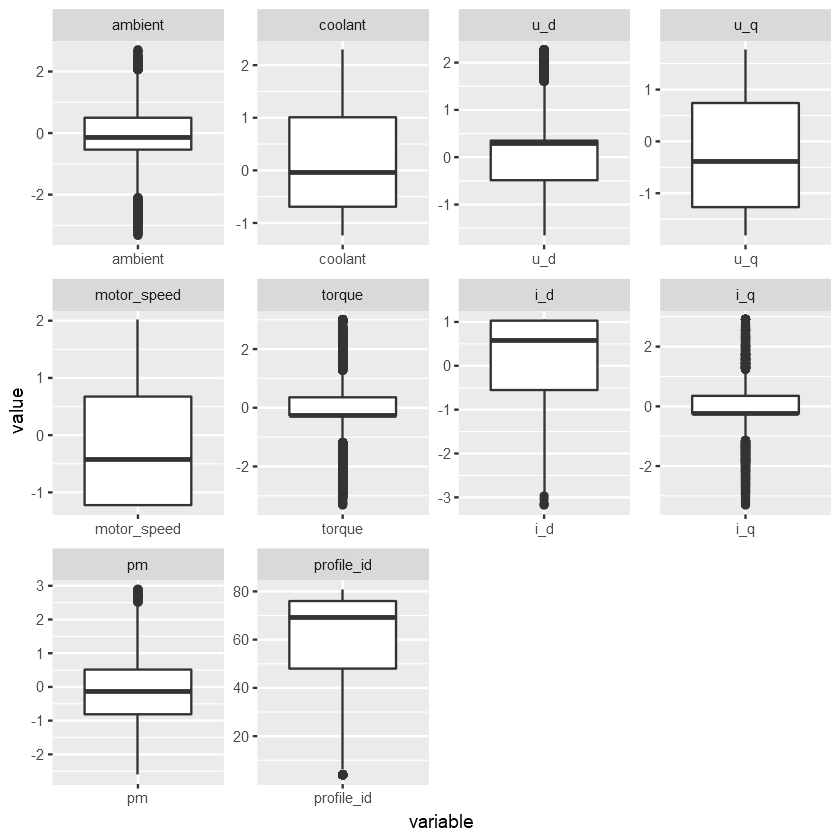

In [11]:
m1 <- melt(as.data.frame(pmsm))
ggplot(m1,aes(x = variable,y = value)) +
facet_wrap(~variable, scales="free") + geom_boxplot() +
scale_y_continuous(labels=function (n) {format(n, scientific=FALSE)})

From the above boxplot we can see there are some feature like __amibiant__ , __u_d__ , __torque__ , __i_q__ and __pm__ that contains some outliers. Dsistrubuation of these may be not normally distributed. We may need to performe some data tramsfortion on these fetures.

#### View the variable distributions using histograms

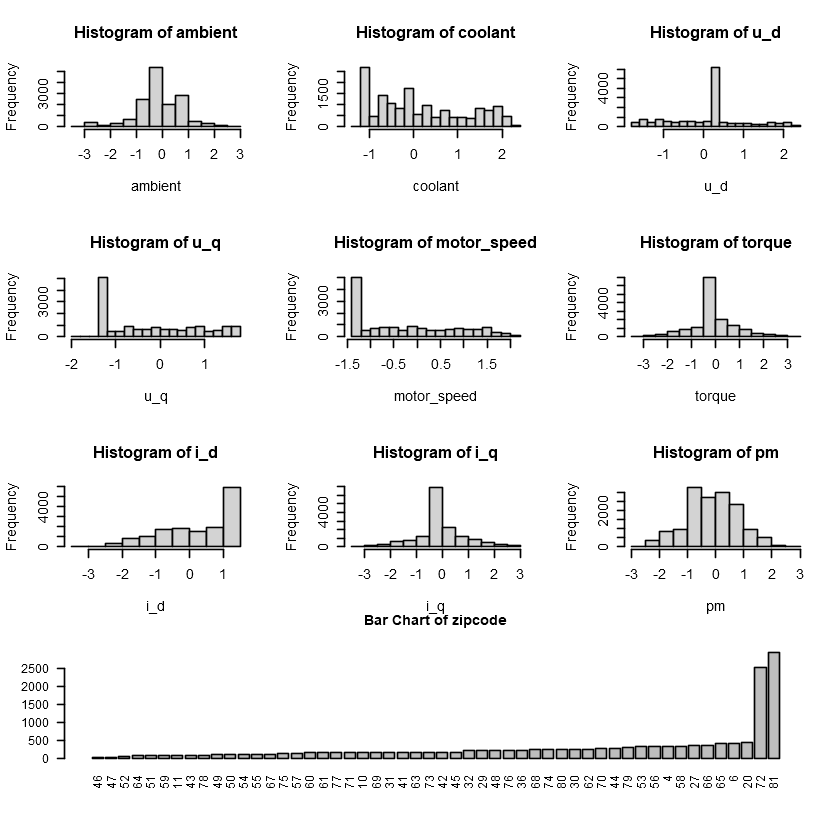

In [12]:
# Plot a histogram or bar chart of each variable
par(mfrow = c(4,3))
hist(ambient)
hist(coolant)
hist(u_d)
hist(u_q)
hist(motor_speed)
hist(torque)
hist(i_d)
hist(i_q)
hist(pm)
# hist(profile_id)

# plot profile_id on a separate row
par(fig=c(0,1,0,0.30),ps=10,new=TRUE)
barplot(sort(table(profile_id)),las=2,main="Bar Chart of zipcode")

We can see above that feture that containts outliers are not normally disturibted.

#### Explore variables with Outliers

Let us observe the distribution of variables with outliers, i.e. __`ambinat`__,__`u_d`__,__`i_q`__ and __`toruqe`__ and __`pm`__.

Histograms for ambient, u_d, i_q and torque

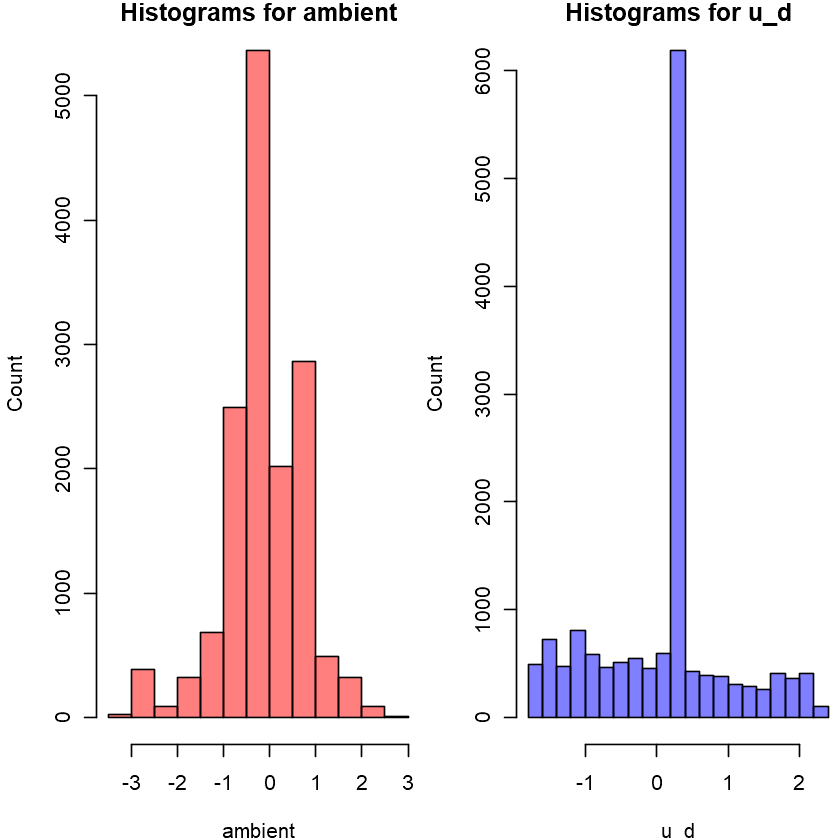

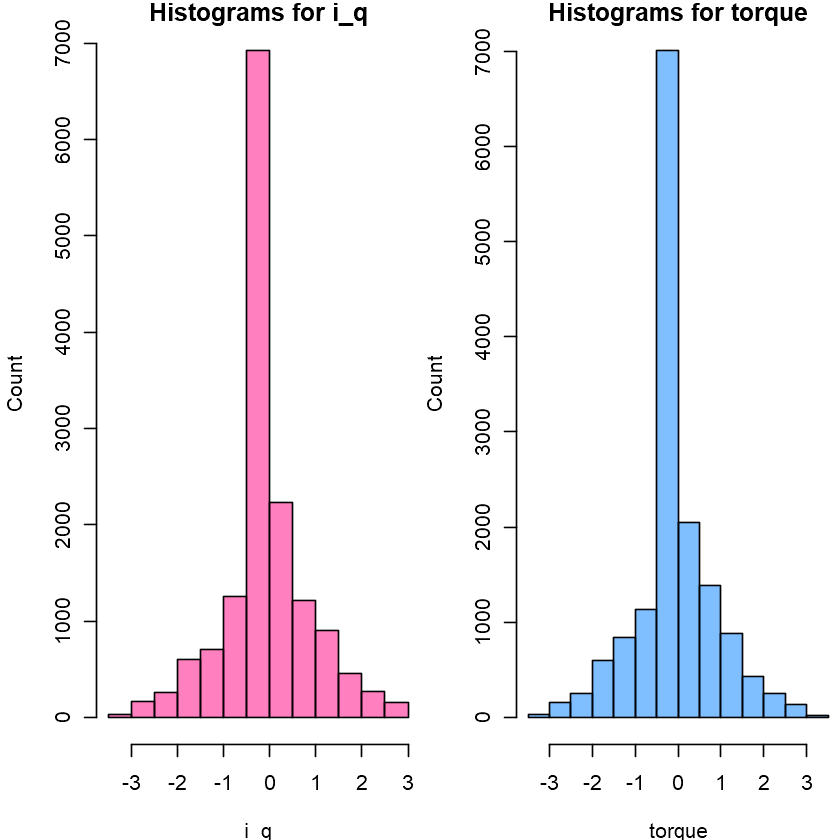

In [13]:
par(
    mfrow=c(1,2),
    mar=c(4,4,1,0)
    )

cat("Histograms for ambient, u_d, i_q and torque")

# Plot a histogram or bar chart of each variable without outliers

#Histogram to plot distribution of 'ambient' variable
hist(pmsm$ambient, col=rgb(1,0,0,0.5) ,
     xlab="ambient" , ylab="Count" , main="Histograms for ambient")

#Histogram to plot distribution of 'u_d' variable
hist(pmsm$u_d, col=rgb(0,0,1,0.5) ,
     xlab="u_d" , ylab="Count" , main="Histograms for u_d")

#Histogram to plot distribution of 'i_q' variable
hist(pmsm$i_q, col=rgb(1,0,0.5,0.5) 
     , xlab="i_q" , ylab="Count" , main="Histograms for i_q")

#Histogram to plot distribution of 'torque' variable
hist(pmsm$torque, col=rgb(0,0.5,1,0.5) ,
     xlab="torque" , ylab="Count" , main="Histograms for torque")

#### Exploring distribution for attributes which has Outliers

Presence of outliers can make data exploration difficult as Outliers have an extreme influence on data.
Thus, we leverage __`Log Transformation`__ or __`sqrt Transformation`__.Here, each variable x is replaced with log(x).

This compresses the y-axis when plotting Histograms for a data with large range of values. Leveraging log of each variable builds better visualisation when Outliers are present in the data.

### Function for data transformation

In [14]:
data.transformation <- function(trans,n){
par(
    mfrow=c(1,2),
    mar=c(4,4,1,0)
    )

#Histogram to plot distribution of 'coolnat' variable
hist(trans(pmsm$coolant+n), main = "Histogram of Log transformed coolant" , 
     col = "green", xlab = "Log(coolnat)")

#Histogram to plot distribution of 'u_q' variable
hist(trans(pmsm$u_q+n), main = "Histogram of Log transformed u_q" ,
     col = "blue", xlab = "Log(u_q)")

#Histogram to plot distribution of 'Solar.Radiation' variable
hist(trans(pmsm$motor_speed+n), main = "Histogram of Log transformed motor_speed" ,
     col = "yellow", xlab = "Log(motor_speed)")
}

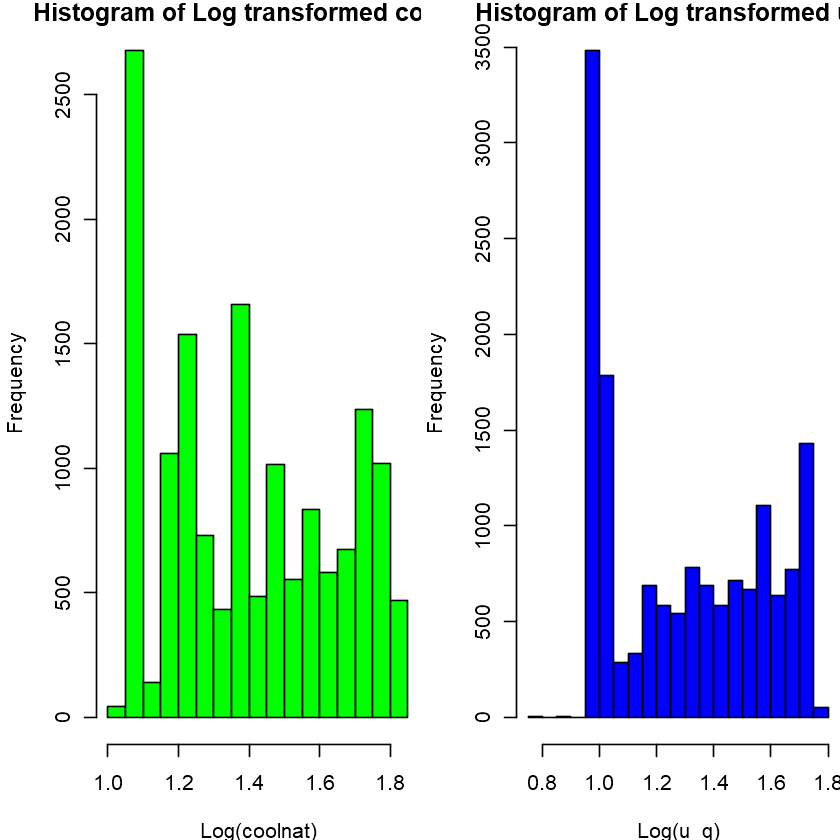

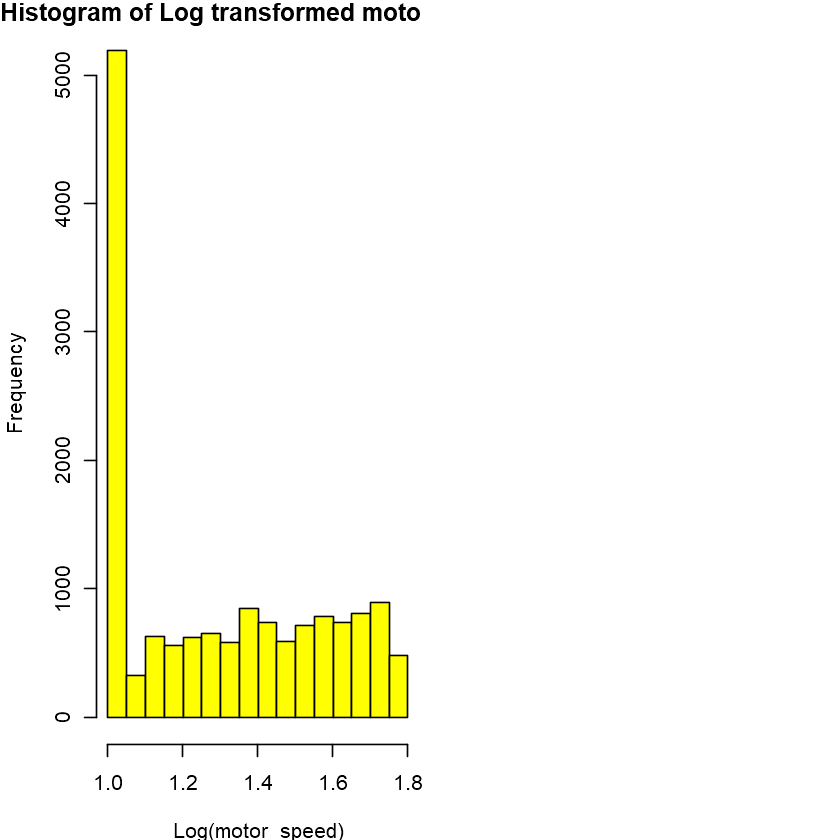

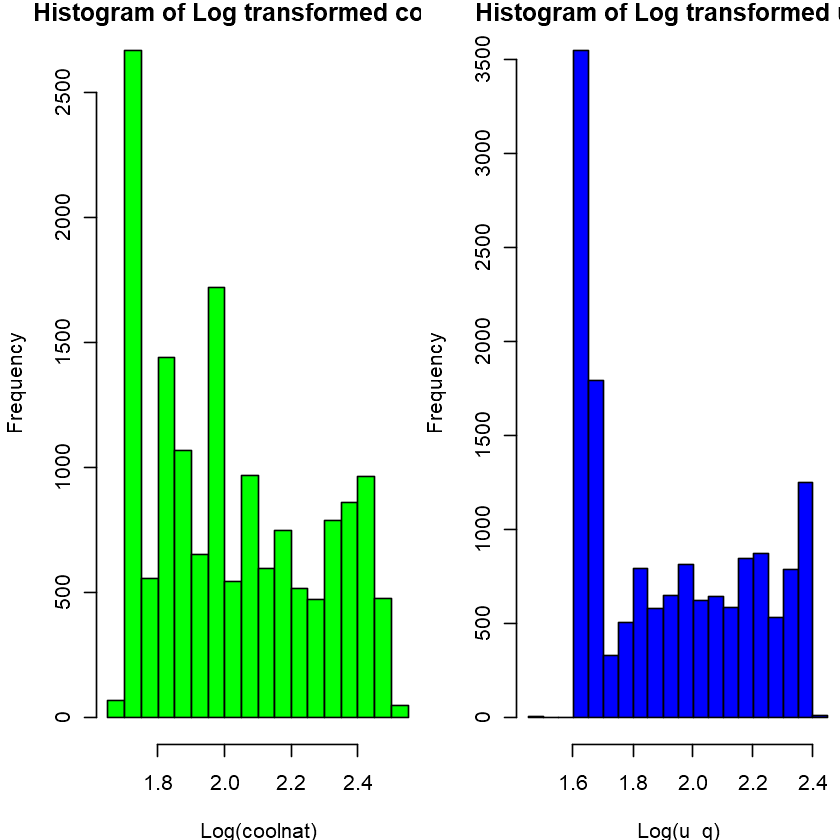

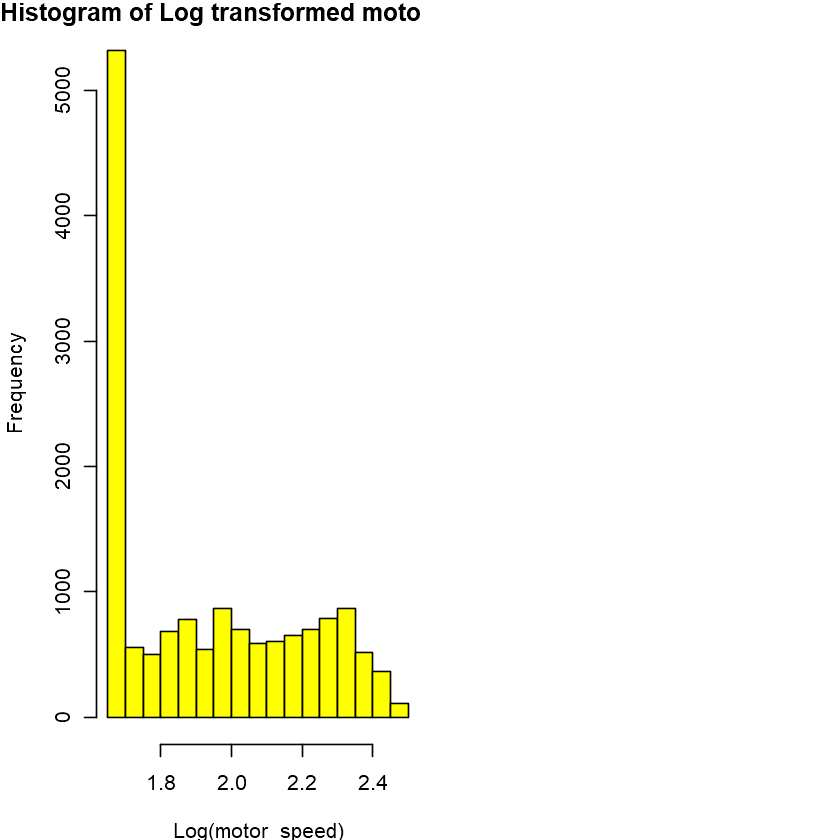

In [15]:
# taking log transformation on data with outliers
data.transformation(log,4)

# taking log transformation on data with outliers
data.transformation(sqrt,4)

After taking the log trasformation data is more skewed than the original distribuation the data. so it will not be a good idea to apply data transformation.

### Explore Target Variable
As the __pm__ attribute has negtive and positive values for certain __profile_id_, Log transformation of the same is necessary as it may mislead the model which will be used to predict the value.
We will consider boxplot of log(__pm__ + 3) as there are many records with less then __-2__ value (log(0)=Inf). This is done to properly visualise the boxplot of target variable, __pm__.

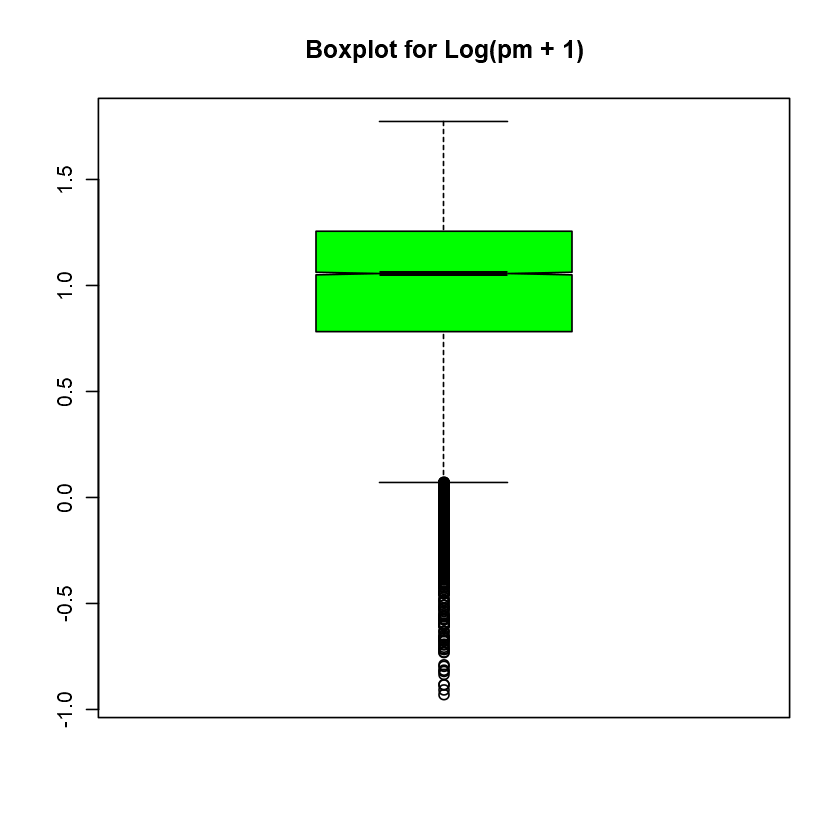

In [16]:
# Boxplot for target variable, pm
boxplot(log(pmsm$pm + 3),
main = " Boxplot for Log(pm + 1) ",
col = "green",
border = "black",
notch = TRUE)

#### Find correlation between different variables
Correlation will give how the features related to each other. They may be positive related means if one variable increase other will increase too or they may negative related means if one decrease other will decrease too.

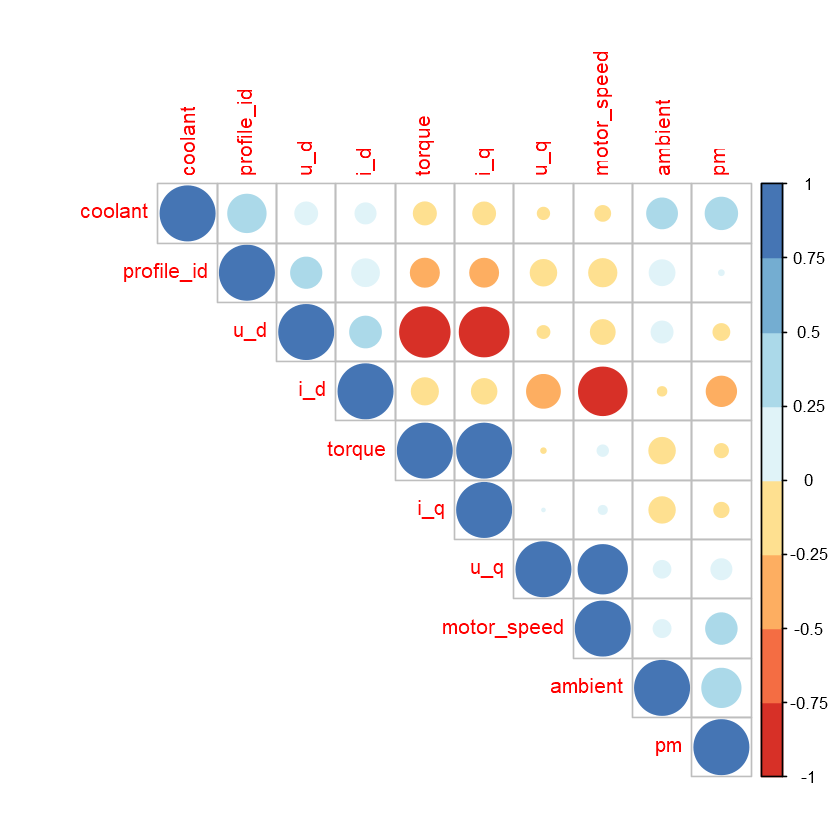

In [17]:
# Level plot to show correlation between various variables using "lattice" package
M <-cor(pmsm)
corrplot(M, type="upper", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

The above correlation plot describes the level of correlation between different variables. The level of corrrelation is visualised using different colours that have a range value from -0.1 to 1. Strong influence of __blue__ color shows high positive correlation while strong influence of __red__ shows high negative correlation.

From the above plot, we can observe that __`i_q`__ has high positive correlation with __`tourque`__. __`u_d`__ has high negative correaltion with both __`tourque`__ and __`i_q`__ variables.

__i_q__ is not weakly releated to other features, so it may be not useful for model accuracy.

In [18]:
#Calculationg correlation between various variables
round(cor(pmsm),2)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,profile_id
ambient,1.00,0.30,0.15,0.09,0.09,-0.22,-0.02,-0.22,0.50,0.21
coolant,0.30,1.00,0.16,-0.04,-0.07,-0.16,0.13,-0.16,0.33,0.47
u_d,0.15,0.16,1.00,-0.04,-0.19,-0.83,0.32,-0.81,-0.08,0.31
u_q,0.09,-0.04,-0.04,1.00,0.80,-0.01,-0.36,0.00,0.13,-0.22
motor_speed,0.09,-0.07,-0.19,0.80,1.00,0.03,-0.77,0.02,0.31,-0.25
torque,-0.22,-0.16,-0.83,-0.01,0.03,1.00,-0.23,1.00,-0.05,-0.26
i_d,-0.02,0.13,0.32,-0.36,-0.77,-0.23,1.00,-0.20,-0.29,0.24
i_q,-0.22,-0.16,-0.81,0.00,0.02,1.00,-0.20,1.00,-0.07,-0.26
pm,0.50,0.33,-0.08,0.13,0.31,-0.05,-0.29,-0.07,1.00,0.01
profile_id,0.21,0.47,0.31,-0.22,-0.25,-0.26,0.24,-0.26,0.01,1.00


## 3. Methodology<a class="anchor" id="sec_4"></a>

### Linear Regrssion 
- The simple linear regression is used to predict a __quantitative outcome y on the basis__ of one single __predictor variable x__. The goal is to build a mathematical model (or formula) that defines y as a function of the x variable.

- Once, we built a statistically significant model, it’s possible to use it for predicting future outcome on the basis of new x values.

- Consider that, we want to evaluate the impact of advertising budgets of three medias (youtube, facebook and newspaper) on future sales. This example of problem can be modeled with linear regression.

Model Fitting is an important consideration while building statistical models. The more number of independent variables in Linear regression models , the variance of the model also increases. Engaging many independent variables can lead to over-fitting.

\begin{equation}
\hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_i + \hat{\epsilon}_i
\end{equation}

### Random Forest for regression

A random forest is a meta estimator that fits a number of __classifying decision trees__ on various __sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting__. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

- The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. 
- To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.

    #### Features of Random Forest

    - Aggregates many decision trees: A random forest is a collection of decision trees and thus, does not rely on       a single feature and combines multiple predictions from each decision tree.
    - Prevents overfitting: With multiple decision trees, each tree draws a sample random data giving the random         forest more randomness to produce much better accuracy than decision trees.
      Advantages of Random Forest


## 4. Model Development <a class="anchor" id="sec_5"></a>

For the prediction task, the underlying problem is to predict the rotor tempera- ture using the collected 8 attributes. The provided data sets are well organised, you do not need to wrangle the data. However, please make sure you understand the intuition of these attributes.<br><br>
To measure the performance of your model(s), you firstly split the original data into training and testing set (profile id. 72 and 81), fit the model using the training set, do the prediction on the test set and compute some performance metrics.
In this task, in addition to the final model, you are also required to
1. compare at least one model that is di↵erent from your final model
2. describe and justify the choice of your models,
3. assess, analyze and interpret your results

In [19]:
# extracting Traning data with profile_id other than 72 and 81
traing_1 <- subset(pmsm, profile_id != 72)
traing_data <- subset(traing_1, profile_id != 81)


# Extracting testing dataset with profile_id 81 and 72
testing_1 <- subset(pmsm, profile_id == 72)
testing_2 <- subset(pmsm, profile_id == 81)
testing_data <- rbind(testing_1,testing_2)

#Drop the profile_id column 
# bike_data_v2 <- bike_data_v2[,-1]

In [20]:
# Display the dimensions
cat("The housing dataset has", dim(traing_data)[1], "records, each with", dim(traing_data)[2],
    "attributes. The some data is:\n\n")
head(traing_data)
cat("The housing dataset has", dim(testing_data)[1], "records, each with", dim(testing_data)[2],
    "attributes. The some data is:\n\n")
head(testing_data)

The housing dataset has 9652 records, each with 10 attributes. The some data is:



,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,profile_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.1176819,-1.040829,-1.0267303,0.9250645,1.2124813,0.3586899,-0.8343090,0.3229330,-0.08831267,4
2,-0.5547717,-1.087189,-1.2258921,0.5125759,2.0241232,0.2841797,-1.3638294,0.2340145,0.71040170,4
3,-0.7722329,-1.063652,0.2988575,0.9562448,-0.1402458,-0.2591392,1.0291220,-0.2457111,-1.59260400,4
4,0.2199584,-1.083475,-1.0261079,0.9278145,1.2124836,0.3574240,-0.8381095,0.3228101,-0.14167030,4
5,0.4015749,-1.078981,0.3155328,-0.7094008,-0.9518901,-0.2562895,1.0291730,-0.2457109,-1.96488810,4
6,-0.7697667,-1.089577,0.2999456,0.9589649,-0.1402460,-0.2592790,1.0291333,-0.2457186,-1.77564350,4


The housing dataset has 5495 records, each with 10 attributes. The some data is:



,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,profile_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
9653,-0.6377452,-0.04413731,1.8582987,-0.1568820,0.1433648,-1.7332261,-0.8766735,-1.6464870,-0.94393826,72
9654,-0.1435436,-0.55148830,0.2989591,-1.2715126,-1.2224310,-0.2556397,1.0291438,-0.2457327,-0.08834702,72
9655,-0.3560795,1.74732000,1.3821719,1.2475253,0.8691434,-0.8936076,-0.1887533,-0.8833676,0.49365747,72
9656,-0.1590795,-0.72017700,0.3498205,-1.2638603,-1.2224305,-0.2556397,1.0291424,-0.2457298,-0.78688150,72
9657,-0.1302600,-0.09398719,-1.1095630,0.4485832,-0.1825359,1.2612251,0.1767561,1.3877791,-0.91363204,72
9658,-0.1410553,-0.83836480,1.0281485,1.4850458,0.9782721,-0.6663674,-0.2154756,-0.6494903,-0.55928590,72


### Define some Functions

These functions are used during the model building to evaluate the model accuracy.<br><br>
#### Function to Calculate Model Accuracy Statistics

Name: Model.Accuracy

Input parameters:
- predicted - a vector of predictions
- target - a vector containing the target values for the predictions 
- df - the degrees of freedom
- p - the number of parameters excluding the coefficient

Return Value:

A list containing:
- rsquared - the R-Squared value calculated from the predicted and target values
- rse - the residual standard error
- f.stat - the F-statistic

Description:

Calculate the TSS and RSS as:
- TSS: $\sum_{i=1}^n (y_i - \bar y)^2$
- RSS: $\sum_{i=1}^n (\hat y_i - y_i)^2$

Calculate the statistics according to the following formulae:
- R-Squared value: $R^2 = 1 - \frac{RSS}{TSS}$
- Residual standard error - $\sqrt{\frac{1}{df}RSS}$
- F-statistics - $\frac{(TSS - RSS)/p}{RSS / df}$

In [21]:
Model.Accuracy <- function(predicted, target, df, p) {
    rss <- 0
    tss <- 0
    target.mean <- mean(target)
    for (i in 1:length(predicted)) {
        rss <- rss + (predicted[i]-target[i])^2
        tss <- tss + (target[i]-target.mean)^2
    }
    rsquared <- 1 - rss/tss
    rse <- sqrt(rss/df)
    f.stat <- ((tss-rss)/p) / (rss/df)
    return(list(rsquared=rsquared,rse=rse,f.stat=f.stat))
}

#### Function to Calculate RMSE

Name: RMSE

Input parameters:
- predicted - a vector of predictions
- target - a vector containing the target values for the predictions 

Return Value:

The RMSE value calculated from the predicted and target values

Description:

Calculate the RMSE value: $RMSE = \sqrt {\sum_{i=1}^n (\hat y_i - y_i)^2 / N}$

In [22]:
RMSE <- function(predicted, target) {
    se <- 0
    for (i in 1:length(predicted)) {
        se <- se + (predicted[i]-target[i])^2
    }
    return (sqrt(se/length(predicted)))
}

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



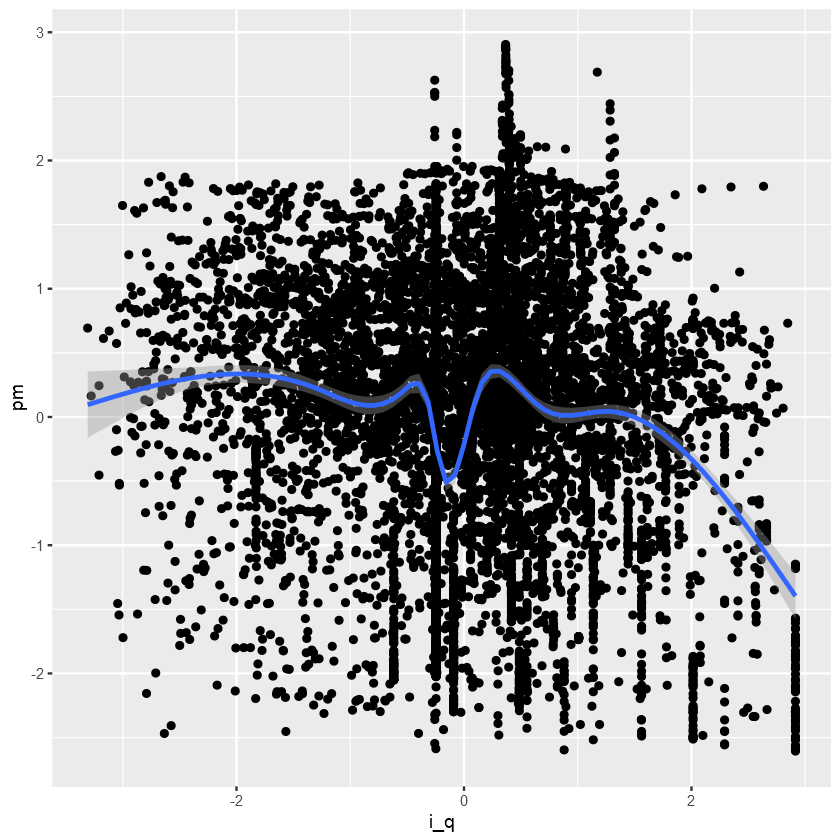

In [23]:
ggplot(traing_data, aes(x = i_q, y = pm)) +
  geom_point() +
  stat_smooth()

### 1.Linear Regression Model

In [24]:
# Performing Linear Regression model to predict pm
lm_fit <- lm(pm ~ ., data=traing_data)

#Display summary of the generated model
summary(lm_fit)


Call:
lm(formula = pm ~ ., data = traing_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6673 -0.4605 -0.0014  0.4566  3.2588 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.2304252  0.0220124  10.468   <2e-16 ***
ambient      0.3868872  0.0085971  45.002   <2e-16 ***
coolant      0.3628844  0.0089860  40.383   <2e-16 ***
u_d         -0.1483211  0.0162073  -9.151   <2e-16 ***
u_q         -0.3499466  0.0159246 -21.975   <2e-16 ***
motor_speed  0.5441924  0.0237023  22.960   <2e-16 ***
torque      -0.2171648  0.1177432  -1.844   0.0652 .  
i_d          0.0322651  0.0168151   1.919   0.0550 .  
i_q          0.1383738  0.1106974   1.250   0.2113    
profile_id  -0.0044434  0.0004158 -10.686   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7181 on 9642 degrees of freedom
Multiple R-squared:  0.4978,	Adjusted R-squared:  0.4973 
F-statistic:  1062 on 9 and 9642 DF,  p-value: < 2.2e

From the above statistics we can observe that,

There are some variables such as __`torque`__,__`i_d`__, and __`i_q`__ which are not very significant for the statisctical model as thier __p-value__ is greater than __0.05__.

Also we can see that __Multiple R-squared value is slightly greater than Adjusted R-squared value__ which is recommeded. The __Adjusted R-squared value__ is __0.4973__ which is Accuracy of the model. Higher the value of $R^2$,better is the model accuracy and model.

The __F-statistic score is 1062__ which shows a __strong relation between dependent and independent variables__. Also, since __p-value is very low__ , we can __reject the null hypothesis__.

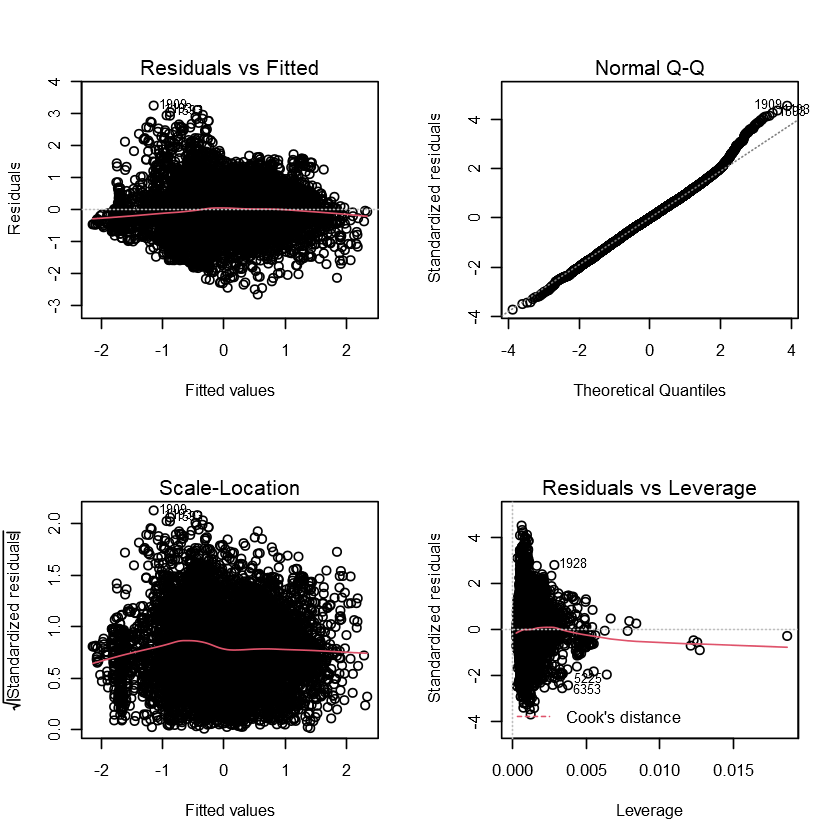

In [25]:
par(mfrow = c(2,2))
#Plot the linear regression model
plot(lm_fit)

The model plots show:
- __Residual vs Fitted__ - shows the residuals reasonably evenly distributed around zero, but they funnel out as the fitted value increases. This model violates the assumption of homoscedasticity - the error terms change along the regression line
- __Normal Q-Q__ - the residuals deviate significantly from the dashed line, indicating the residuals are not normally distributed
- __Scale-Location__ - The chart shows the model violates the assumption of equal variance
- __Residuals vs Leverage__ - The chart shows there are some possibly influential outliers, however they appear to cancel each other out

This plot helps to see wheather the plot is overfit or under fit.

#### Stepwise Linear Regression Model 

We will be using forward stepwise selection procedure to determine the best combination of independent variables for prediction of the response variable.

We will be using `step()` function for the same.

In [26]:
step_fit <- step(lm_fit)
summary(step_fit)

Start:  AIC=-6383.76
pm ~ ambient + coolant + u_d + u_q + motor_speed + torque + i_d + 
    i_q + profile_id

              Df Sum of Sq    RSS     AIC
- i_q          1      0.81 4972.2 -6384.2
<none>                     4971.4 -6383.8
- torque       1      1.75 4973.2 -6382.4
- i_d          1      1.90 4973.3 -6382.1
- u_d          1     43.18 5014.6 -6302.3
- profile_id   1     58.87 5030.3 -6272.1
- u_q          1    248.99 5220.4 -5914.1
- motor_speed  1    271.79 5243.2 -5872.0
- coolant      1    840.84 5812.2 -4877.5
- ambient      1   1044.17 6015.6 -4545.6

Step:  AIC=-6384.19
pm ~ ambient + coolant + u_d + u_q + motor_speed + torque + i_d + 
    profile_id

              Df Sum of Sq    RSS     AIC
<none>                     4972.2 -6384.2
- i_d          1      2.78 4975.0 -6380.8
- torque       1     11.87 4984.1 -6363.2
- u_d          1     46.60 5018.8 -6296.1
- profile_id   1     60.58 5032.8 -6269.3
- u_q          1    248.24 5220.4 -5915.9
- motor_speed  1    275.08 524


Call:
lm(formula = pm ~ ambient + coolant + u_d + u_q + motor_speed + 
    torque + i_d + profile_id, data = traing_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6709 -0.4612 -0.0020  0.4568  3.2693 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.2326914  0.0219383  10.607  < 2e-16 ***
ambient      0.3877259  0.0085712  45.236  < 2e-16 ***
coolant      0.3628046  0.0089860  40.374  < 2e-16 ***
u_d         -0.1398029  0.0147055  -9.507  < 2e-16 ***
u_q         -0.3485000  0.0158830 -21.942  < 2e-16 ***
motor_speed  0.5462092  0.0236480  23.097  < 2e-16 ***
torque      -0.0711561  0.0148318  -4.798 1.63e-06 ***
i_d          0.0376930  0.0162452   2.320   0.0203 *  
profile_id  -0.0044895  0.0004142 -10.839  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7181 on 9643 degrees of freedom
Multiple R-squared:  0.4977,	Adjusted R-squared:  0.4973 
F-statistic:  1194 on 8 and 9643 

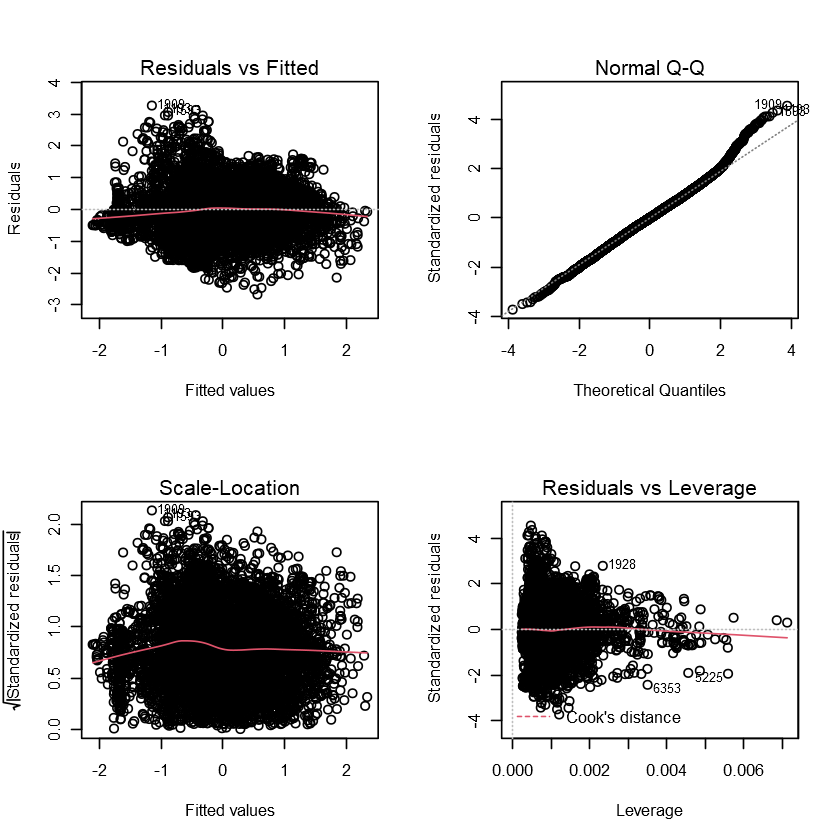

In [27]:
par(mfrow = c(2,2))
#Plot the linear regression model
plot(step_fit)

The results of plot for Linear Regression and Stepwise Linear regression are very similar.

On observing the results from Stepwise Linear Regression and comparing them with Linear Regression, we can observe that `i_q` is removed as a predictor variable as their value was less than __0.05__. Also, as we observed __from correlation analysis i_q had very low correlation__ with other variables. Thus, we can say that `i_q` is not significant for generating the model. This was an observation in previous model as well.


The insights from Stepwise Linear Regression Model are very much similar to Linear Regression model built previously.

### Model 2: Regression using Random Forest
Random Forest Regression is a collection of trees and does not heavily rely on a single variable. Multiple prediction for each tree are leveraged and also provides higher accuracy.

Here,\
ntree= number of trees \
mtry= number of variables sampled as candidates for each split \
nodesize= minimum size of terminal nodes

In [28]:
# Generating model using Random Forest for Regression
r_fit = randomForest(x = traing_data ,
        y = traing_data$pm, ntree = 200 , mtry = 5, nodesize = 2)

print(r_fit)


Call:
 randomForest(x = traing_data, y = traing_data$pm, ntree = 200,      mtry = 5, nodesize = 2) 
               Type of random forest: regression
                     Number of trees: 200
No. of variables tried at each split: 5

          Mean of squared residuals: 0.0002904025
                    % Var explained: 99.97


As we can see we are getting good accuracy around 99%, but we can still check for more imrovement by findinh out correct number of mtry and tree size.

mtry = 3  OOB error = 0.09590894 
Searching left ...
mtry = 6 	OOB error = 0.08018103 
0.163988 0.05 
mtry = 12 	OOB error = 0.07689099 
0.04103261 0.05 
Searching right ...
mtry = 1 	OOB error = 0.1549447 
-0.9324354 0.05 


,mtry,OOBError
1,1,0.15494466
3,3,0.09590894
6,6,0.08018103
12,12,0.07689099


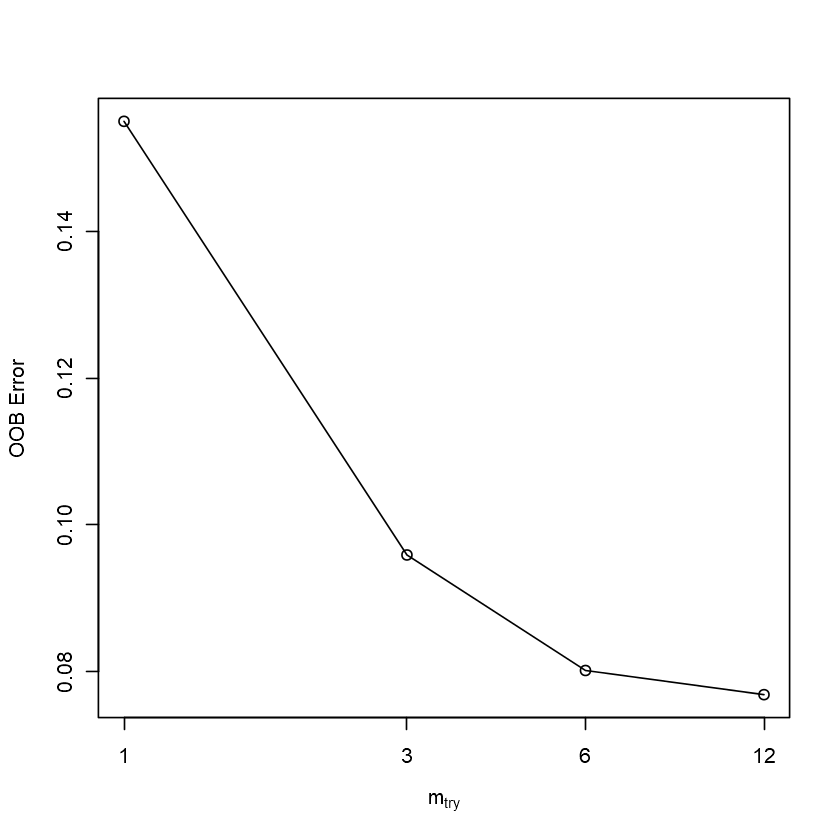

In [29]:
# Finding out coreect mtry number and number of tree
tuneRF(traing_data[,-9,-10], traing_data[,9], 
       stepFactor = 0.5, plot = TRUE, 
       ntreeTry = 300, trace = TRUE, improve = 0.05)

After runing __tunRf__ we can see the correct number for mtry and tree size is __12__ and __300__ respectively. At __mtry 12__ the bag of error is least as compared to mtry number.we can also check the __importance features__ that plays important role in accuracy.

Dotchart of variable importance as measured by a Random Forest.

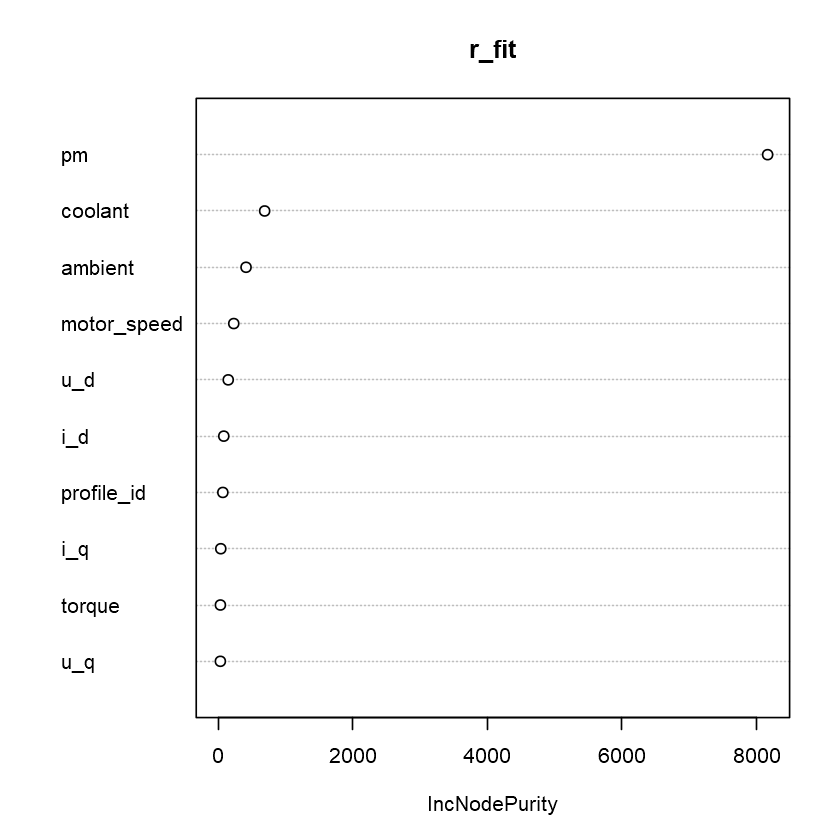

In [30]:
varImpPlot(r_fit)

As we can see from the above graph all the feature are contributing same for the model when it comes to model accuracy.So we just change mtry and number of tree in our model. 

In [31]:
# Generating model using Random Forest for Regression
r_fit = randomForest(x = traing_data ,
        y = traing_data$pm, ntree = 300 , mtry = 12, nodesize = 2)

print(r_fit)


Call:
 randomForest(x = traing_data, y = traing_data$pm, ntree = 300,      mtry = 12, nodesize = 2) 
               Type of random forest: regression
                     Number of trees: 300
No. of variables tried at each split: 10

          Mean of squared residuals: 1.751725e-06
                    % Var explained: 100


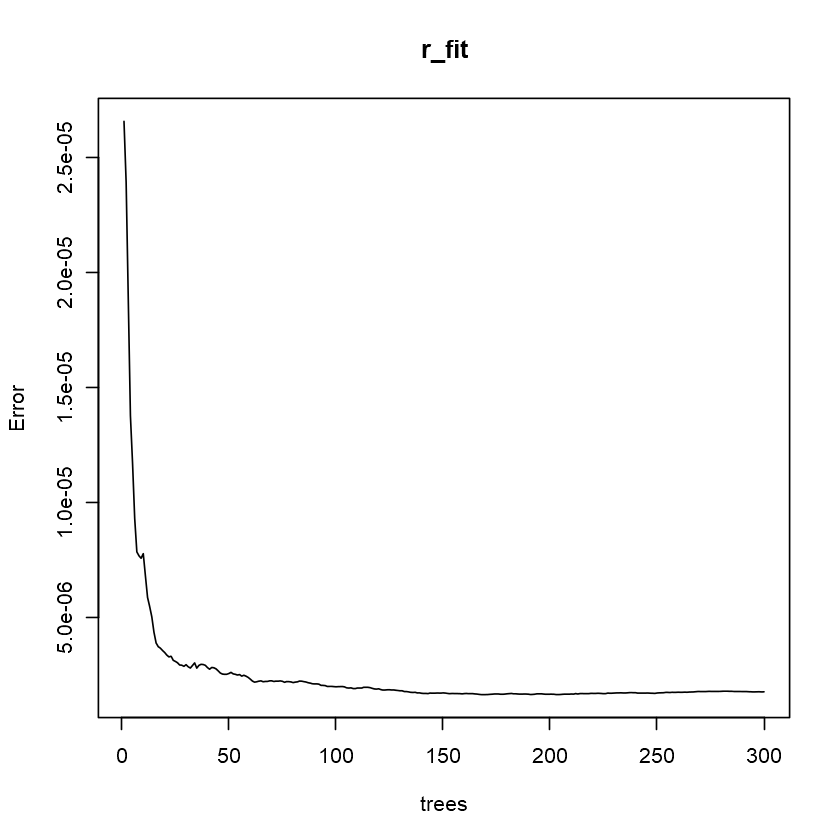

In [32]:
plot(r_fit)

The above-mentioned plotted error rate is based on the OOB sample error.\
The number of trees with lowest MSE are __300__.

So in our final Random forest model we will keep __ntree=300__ and __mtry=12__

## 5. Results and discussion <a class="anchor" id="sec_6"></a>

#### LINEAR REGRESSION 

In [33]:
# Predict the pm through Linear Regression Model
lm_predict <- predict (lm_fit,testing_data)

#Calculate MAE of the pm predicted
MAE_lm <- mae(lm_predict,testing_data$pm)

#Calculate MSE of the pm predicted
MSE_lm <-mse(lm_predict,testing_data$pm)

#Calculate RMSE of the pm predicted
RMSE_lm <- rmse(lm_predict,testing_data$pm)

#Calculate R-squared value of the pm predicted
R2_lm <-R2(lm_predict,testing_data$pm, form = "traditional")


cat("Using Linear Regression", "\n", "\tMAE:", MAE_lm, "\n", "\tMSE:", MSE_lm, "\n", 
    "\tRMSE:", RMSE_lm, "\n", "\tR-squared:", R2_lm)

Using Linear Regression 
 	MAE: 0.565103 
 	MSE: 0.4586256 
 	RMSE: 0.677219 
 	R-squared: -0.04627104

#### STEPWISE MODEL

In [34]:
# Predict the pm through Linear Regression Model
step_predict <- predict (step_fit,testing_data)

#Calculate MAE of the pm predicted
MAE_lm <- mae(step_predict,testing_data$pm)

#Calculate MSE of the pm predicted
MSE_lm <-mse(step_predict,testing_data$pm)

#Calculate RMSE of the pmt predicted
RMSE_lm <- rmse(step_predict,testing_data$pm)

#Calculate R-squared value of the pm predicted
R2_lm <-R2(step_predict,testing_data$pm, form = "traditional")


cat("Using stepwised Regression", "\n", "\tMAE:", MAE_lm, "\n", "\tMSE:", MSE_lm, "\n", 
    "\tRMSE:", RMSE_lm, "\n", "\tR-squared:", R2_lm)

Using stepwised Regression 
 	MAE: 0.564969 
 	MSE: 0.4582669 
 	RMSE: 0.6769542 
 	R-squared: -0.04545272

#### RANDOM FOREST MODEL

In [35]:
# Predict the pm through Linear Regression Model
random_predict <- predict (r_fit,testing_data)

#Calculate MAE of the pm predicted
MAE_lm <- mae(random_predict,testing_data$pm)

#Calculate MSE of the pm predicted
MSE_lm <-mse(random_predict,testing_data$pm)

#Calculate RMSE of the pm predicted
RMSE_lm <- rmse(random_predict,testing_data$pm)

#Calculate R-squared value of the pm predicted
R2_lm <-R2(random_predict,testing_data$pm, form = "traditional")


cat("Using Linear Regression", "\n", "\tMAE:", MAE_lm, "\n", "\tMSE:", MSE_lm, "\n", 
    "\tRMSE:", RMSE_lm, "\n", "\tR-squared:", R2_lm)

Using Linear Regression 
 	MAE: 0.0003259681 
 	MSE: 2.90513e-07 
 	RMSE: 0.0005389926 
 	R-squared: 0.9999993

|SR.NO.   |Model                       |MAE               |MSE           |RMSE         |R-squared    |
|---------|----------------------------|------------------|--------------|-------------|-------------|
|1.A      |Linear Regression           |0.565103          |0.565103      |0.677219     |-0.04627104  |
|1.B      |Stepwise Linear Regression  |0.564969          |0.4582669     |0.6769542    |-0.04545272  |
|2        |Random Forest               |0.0003180223      |2.414307e-07  |0.0004913559 |0.9999994    |

From the statistical inference calculated for all the three models we can observe that the __R-squared value__ for __Linear regression models__ i.e. through Linear Regression and Stepwise Linear regression is almost same which is __-0.04627104 and -0.04545272__ respectively. That also mean all the feature that is used in linear regression model is important, that we also seen in randomforest model. 

But when we compare the these to model with __random forest model__, the __R-squared value__ which is same accuracy is almost 100% and much greater.

Thus, based on __R-squared value we can say that Random Forest model for Regression is the best__.

We can also see that __root mean square error__ values for both Linear Regresion models is similar i.e.__0.677219 and 0.6769542__ for __Linear regression and Stepwise Linear Regression__ respectively which are high. when ever __RMSE__ value for any model is high that means model is not performing well and their accuracy also very poor. So , __RMSE__ and __R-squared__ is inversly prposal to eac other.However, the RMSE values is reduced in 
But when we compare the these to model with __random forest model__ with __0.0004913559__ value. This value is less than Linear Regression Models.

Thus, after comapring __RMSE__ and __R-squared__ overall we can say that __Random Forest is the best Statistical model for predicting the rotor tempreature of a given machine__.

## 6. Conclusion<a class="anchor" id="sec_7"></a>

- the rotor temperatures of a permanent magnet synchronous motor (PMSM) in real-time dataset contains only interger value except for profile_id column.
- Due to the intricate structure of an electric traction drive, direct measurement with thermal sensors is not possible for rotor temperatures, and even in case of the stator temperatures, sensor outage or even just deterioration can’t be ad- ministered properly without redundant modeling.
- Out of 13 feture we are not going to consider __stator yoke__, __stator winding__ and __stator tooth__ as they are relevent to our Statstical modeling.
- All the colunn has negative and postive value and they are ranges from around __-4__ to __4__.
- rotor temperature is less for initial prfile id but it goes on increasing as the prfofile id increase.
- There are Features which have high positive correlation coefficients such as  like __torque__ and __i_q__, __u_q__ and __motor_speed__ with other variables.Thus, increase in value of one variable ,increases the value of corresponding variable.
- There are variables with high negative correlation coefficients such as __u_d:i_q__, __u_d:torque__.Thus, with increase in value of a variable, decreases the value of other corresponding variable.
-  __`ambinat`__,__`u_d`__,__`i_q`__ and __`toruqe`__ and __`pm`__ have huge range of values. As observed, outliers are present for these variables.
- We have built three statistical models, __Linear Regression model__ and __Random Forest for Regression__.
- After the EDA, i seen some conatins outliers and becouse of that data is left or right skweed.
- Perfrom some data transformation to skweed data to make data normal like __log transformation__ and __sqrt transformation__.


## 7. References <a class="anchor" id="sec_8"></a>

[1] Jason B. (3 February, 2016). *Your First Machine Learning Project in R Step-By-Step* .<br>Retrieved from: https://machinelearningmastery.com/machine-learning-in-r-step-by-step/ \
[2] Nathan Y. (2018). *Visualizing Outliers* .<br>Retrieved from: https://flowingdata.com/2018/03/07/visualizing-outliers/ \
[3] PennState (2020). *Cross-validation Tutorial* .<br>Retrieved from: https://quantdev.ssri.psu.edu/tutorials/cross-validation-tutorial \
[4] Perceptive Analytics (9 August, 2018). *Building Regression Models in R using Support Vector Regression* .<br>Retrieved from: https://www.perceptive-analytics.com/building-regression-models-r-using-support-vector-regression/#:~:text=Building%20Regression%20Models%20in%20R%20using%20Support%20Vector%20Regression,-Analytics%20%7C%20August%209&text=SVR%20uses%20the%20same%20basic,provides%20a%20proficient%20prediction%20model. \
[5] PennState (2020). *Cross-validation Tutorial* .<br>Retrieved from: https://quantdev.ssri.psu.edu/tutorials/cross-validation-tutorial \
[6] Alakh S. (27 March, 2020). *Support Vector Regression Tutorial for Machine Learning* .<br>Retrieved from: https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/ \
[7] Engineering Statistics Handbook. *Measures of Skewness and Kurtosis* .<br>Retrieved from: https://itl.nist.gov/div898/handbook/eda/section3/eda35b.htm \
[8] Khan Academy. *Mean absolute deviation (MAD)* .<br>Retrieved from: https://www.khanacademy.org/math/cc-sixth-grade-math/cc-6th-data-statistics/cc-6-mad/v/mean-absolute-deviation#:~:text=Mean%20absolute%20deviation%20(MAD)%20of,in%20a%20data%20set%20are. \
[9] Holly E. (8 August, 2018). *When to use a Trimmed Mean* .<br>Retrieved from: https://medium.com/@HollyEmblem/when-to-use-a-trimmed-mean-fd6aab347e46 \
[10] R Documentation (10 April, 2018). *rmse* .<br>Retrieved from: https://www.rdocumentation.org/packages/Metrics/versions/0.1.4/topics/rmse \
[11] Steven B. (2017). *Statistical Models in R* .<br>Retrieved from: https://www3.nd.edu/~steve/Rcourse/Lecture8v1.pdf \
[12] https://cran.r-project.org/web/packages/dlookr/vignettes/EDA.html
[13] https://www.geeksforgeeks.org/random-forest-approach-for-regression-in-r-programming/